# 毕业项目：检测分神司机

In [1]:
%config InlineBackend.figure_format = 'retina'

from urllib.request import urlretrieve
from os.path import isfile, isdir, join, pardir
from IPython.display import SVG, Image
import os, shutil
import random
import glob
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.utils import to_categorical
from keras import regularizers

from keras.applications import inception_resnet_v2
from keras.applications.inception_resnet_v2 import InceptionResNetV2


import pydot
import cv2
import h5py

Using TensorFlow backend.


In [2]:
driver_dataset_folder_path = join(pardir, 'data', 'driver_dataset')
image_train_folder_path = join(pardir, 'data', 'driver_dataset', 'train')
image_test_floder_path = join(pardir, 'data', 'driver_dataset', 'test')
image_valid_folder_path = join(pardir, 'data', 'driver_dataset', 'valid')

inceptionresnetv2_train_datagen = ImageDataGenerator(
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    preprocessing_function=inception_resnet_v2.preprocess_input)

inceptionresnetv2_valid_datagen = ImageDataGenerator(
    preprocessing_function=inception_resnet_v2.preprocess_input)


inceptionresnetv2_train_generator = inceptionresnetv2_train_datagen.flow_from_directory(
    image_train_folder_path,
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical')

inceptionresnetv2_valid_generator = inceptionresnetv2_valid_datagen.flow_from_directory(
    image_valid_folder_path,
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    shuffle=False)

/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:504: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 20097 images belonging to 10 classes.
Found 2327 images belonging to 10 classes.


### 二、创建模型

In [3]:
model_inceptionresnetv2 = InceptionResNetV2(include_top=False, weights='imagenet')

#print('Print inceptionresnetv2 model summary:')
#print(model_inceptionresnetv2.summary())
for i, layer in enumerate(model_inceptionresnetv2.layers):
    print (i, layer.name)
        
input = Input(shape=(299, 299, 3),name = 'image_input')

output_inceptionresnetv2_conv = model_inceptionresnetv2(input)
x = GlobalAveragePooling2D()(output_inceptionresnetv2_conv)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed_5b
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 conv2d_13
51 conv2d_15
52 conv2d_18
53 batch_normalization_13
54 batch_normalization_15
55 batch_normalization

### 三、模型微调
#### 1. 锁定InceptionResNetV2模型前274层

In [4]:
model_274 = Model(input=input, output=x)

for i in range(274):
    model_inceptionresnetv2.layers[i].trainable = False
    
adam = optimizers.Adam(lr=1e-4)
model_274.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [7]:
history_inceptionresnetv2_finetune_274 = model_274.fit_generator(
    inceptionresnetv2_train_generator,
    epochs=5,
    validation_data=inceptionresnetv2_valid_generator)

Epoch 1/5


/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:571: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:579: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


315/315 [==============================] - 1062s 3s/step - loss: 0.4978 - categorical_accuracy: 0.9003 - val_loss: 0.5624 - val_categorical_accuracy: 0.9037
Epoch 2/5
315/315 [==============================] - 1056s 3s/step - loss: 0.1920 - categorical_accuracy: 0.9899 - val_loss: 0.6214 - val_categorical_accuracy: 0.8805
Epoch 3/5
315/315 [==============================] - 1055s 3s/step - loss: 0.1573 - categorical_accuracy: 0.9908 - val_loss: 0.5459 - val_categorical_accuracy: 0.9007
Epoch 4/5
315/315 [==============================] - 1055s 3s/step - loss: 0.1202 - categorical_accuracy: 0.9968 - val_loss: 0.4417 - val_categorical_accuracy: 0.9063
Epoch 5/5
315/315 [==============================] - 1056s 3s/step - loss: 0.0986 - categorical_accuracy: 0.9944 - val_loss: 0.4450 - val_categorical_accuracy: 0.9145


In [8]:
model_274.save(join(pardir, 'model', 'Inceptionresnetv2_finetune_274.h5'))
print("Inceptionresnetv2 model saved.")

Inceptionresnetv2 model saved.


{'loss': [0.4928053226282082, 0.18456540364213575, 0.14992289371844483, 0.11496310894979365, 0.0912512431377474], 'val_loss': [0.5623507166195695, 0.6213925025162904, 0.5459059294990373, 0.4417316576007307, 0.444979562439732], 'categorical_accuracy': [0.90311986863711, 0.9930337861372344, 0.9938796835348559, 0.9968154450913072, 0.9975120664775837], 'val_categorical_accuracy': [0.9037387193299488, 0.8805328749078613, 0.9007305543874536, 0.9063171464637672, 0.9144821660068858]}


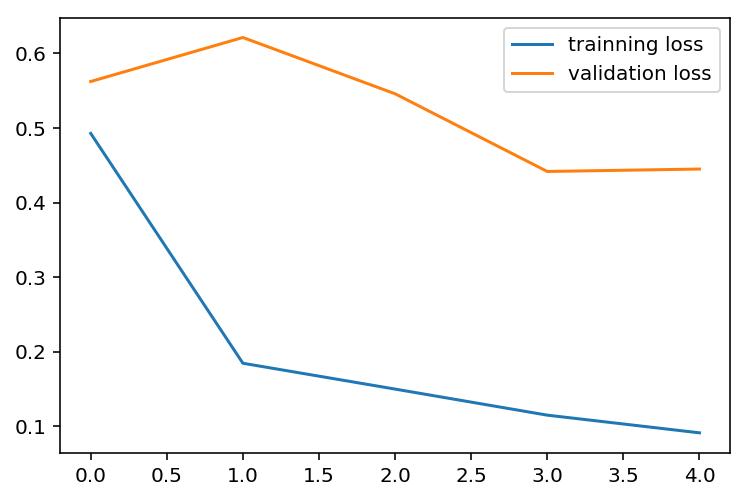

In [9]:
print (history_inceptionresnetv2_finetune_274.history)
plt.plot (history_inceptionresnetv2_finetune_274.history['loss'], label="trainning loss")
plt.plot (history_inceptionresnetv2_finetune_274.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

#### 2. 锁定InceptionResNetV2模型前616层

In [4]:
model_616 = Model(input=input, output=x)

for i in range(616):
    model_inceptionresnetv2.layers[i].trainable = False
    
adam = optimizers.Adam(lr=1e-4)
model_616.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history_inceptionresnetv2_finetune_616 = model_616.fit_generator(
    inceptionresnetv2_train_generator,
    epochs=5,
    validation_data=inceptionresnetv2_valid_generator)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("im...)`
  """Entry point for launching an IPython kernel.


Epoch 1/5


/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:571: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:579: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


315/315 [==============================] - 663s 2s/step - loss: 0.6482 - categorical_accuracy: 0.8496 - val_loss: 0.8805 - val_categorical_accuracy: 0.8187
Epoch 2/5
315/315 [==============================] - 641s 2s/step - loss: 0.2318 - categorical_accuracy: 0.9814 - val_loss: 0.7040 - val_categorical_accuracy: 0.8410
Epoch 3/5
315/315 [==============================] - 638s 2s/step - loss: 0.1844 - categorical_accuracy: 0.9865 - val_loss: 0.7592 - val_categorical_accuracy: 0.8496
Epoch 4/5
315/315 [==============================] - 637s 2s/step - loss: 0.1472 - categorical_accuracy: 0.9895 - val_loss: 0.7572 - val_categorical_accuracy: 0.8552
Epoch 5/5
315/315 [==============================] - 637s 2s/step - loss: 0.1195 - categorical_accuracy: 0.9921 - val_loss: 0.5970 - val_categorical_accuracy: 0.8698


In [5]:
model_616.save(join(pardir, 'model', 'Inceptionresnetv2_finetune_616.h5'))
print("Inceptionresnetv2 model saved.")

/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:571: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:579: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Inceptionresnetv2 model saved.


{'val_categorical_accuracy': [0.8186506231711256, 0.8409969917837519, 0.8495917488922108, 0.855178340955717, 0.8697894283974176], 'loss': [0.642807113120062, 0.22394156523614983, 0.17464641973783337, 0.1394625105133945, 0.1119190584802388], 'val_loss': [0.8805399359066598, 0.7039983414968402, 0.7592095387151019, 0.7571845316917639, 0.5970369749024133], 'categorical_accuracy': [0.8522665074389212, 0.9844752948201224, 0.9895506792058516, 0.9925859581031995, 0.9951734089665124]}


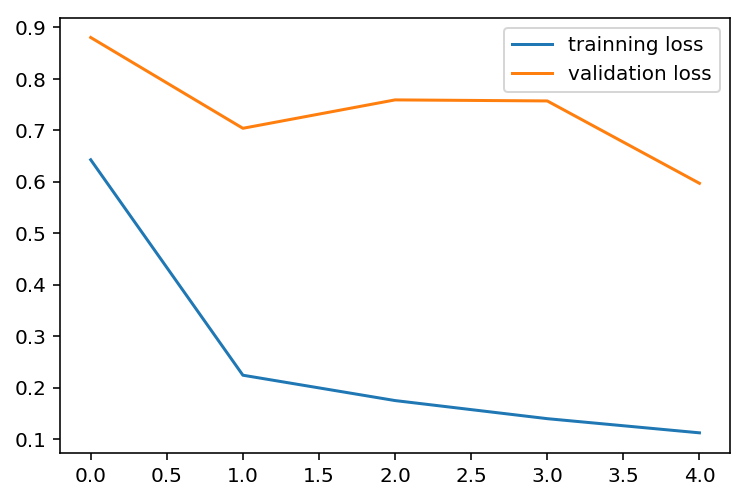

In [6]:
print (history_inceptionresnetv2_finetune_616.history)
plt.plot (history_inceptionresnetv2_finetune_616.history['loss'], label="trainning loss")
plt.plot (history_inceptionresnetv2_finetune_616.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

#### 3. 锁定InceptionResNetV2模型前40层

In [12]:
model_40 = Model(input=input, output=x)

for i in range(40):
    model_inceptionresnetv2.layers[i].trainable = False
    
adam = optimizers.Adam(lr=1e-4)
model_40.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history_inceptionresnetv2_finetune_40 = model_40.fit_generator(
    inceptionresnetv2_train_generator,
    epochs=5,
    validation_data=inceptionresnetv2_valid_generator)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("im...)`
  """Entry point for launching an IPython kernel.


Epoch 1/5


/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:571: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:579: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


315/315 [==============================] - 659s 2s/step - loss: 0.0926 - categorical_accuracy: 0.9914 - val_loss: 0.7157 - val_categorical_accuracy: 0.8543
Epoch 2/5
315/315 [==============================] - 643s 2s/step - loss: 0.0753 - categorical_accuracy: 0.9940 - val_loss: 0.8196 - val_categorical_accuracy: 0.8199
Epoch 3/5
315/315 [==============================] - 643s 2s/step - loss: 0.0629 - categorical_accuracy: 0.9949 - val_loss: 0.6634 - val_categorical_accuracy: 0.8573
Epoch 4/5
315/315 [==============================] - 643s 2s/step - loss: 0.0545 - categorical_accuracy: 0.9934 - val_loss: 0.8179 - val_categorical_accuracy: 0.8281
Epoch 5/5
315/315 [==============================] - 643s 2s/step - loss: 0.0466 - categorical_accuracy: 0.9942 - val_loss: 0.6232 - val_categorical_accuracy: 0.8522


In [13]:
model_40.save(join(pardir, 'model', 'Inceptionresnetv2_finetune_40.h5'))
print("Inceptionresnetv2 model saved.")

/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:571: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:579: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Inceptionresnetv2 model saved.


{'val_categorical_accuracy': [0.8543188653639779, 0.819939836750842, 0.8573270304729665, 0.8281048558969378, 0.8521701764230519], 'loss': [0.08639783128942549, 0.06957053105475364, 0.05728160664116665, 0.04684110830724313, 0.03973225826065641], 'val_loss': [0.7156542989897225, 0.8196033734746588, 0.6634118269070771, 0.8179320868474503, 0.6232110126417084], 'categorical_accuracy': [0.9945265462506842, 0.9939792008757526, 0.9949246156142708, 0.9965168930686172, 0.9973130317957905]}


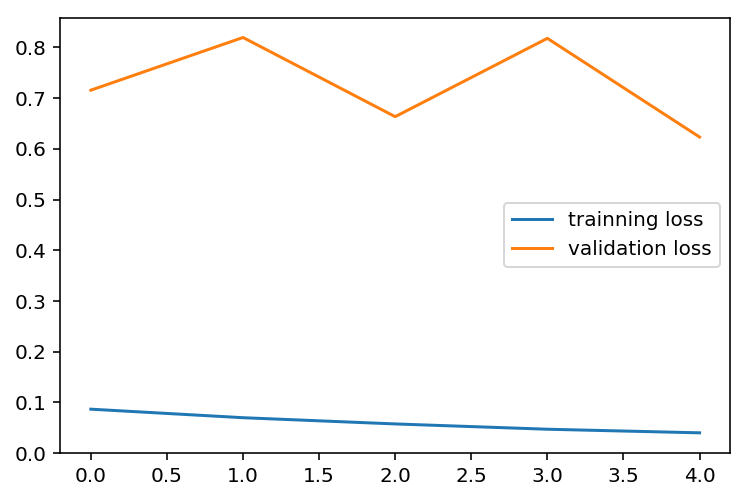

In [14]:
print (history_inceptionresnetv2_finetune_40.history)
plt.plot (history_inceptionresnetv2_finetune_40.history['loss'], label="trainning loss")
plt.plot (history_inceptionresnetv2_finetune_40.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

### 四、模型预测
准备测试集数据

In [7]:
test_image_path = join(driver_dataset_folder_path, 'test')
Inceptionresnetv2_test_datagen = ImageDataGenerator(preprocessing_function=inception_resnet_v2.preprocess_input)
Inceptionresnetv2_test_generator = Inceptionresnetv2_test_datagen.flow_from_directory(
    test_image_path,
    target_size=(299, 299),
    batch_size=32,
    shuffle=False,
    class_mode='categorical')

Found 79726 images belonging to 1 classes.


#### 1.model_Inceptionresnetv2_finetune_274
模型加载

In [7]:
model_Inceptionresnetv2_finetune_274 = load_model(join(pardir, 'model', 'Inceptionresnetv2_finetune_274.h5'))
print("Model loaded.")

Model loaded.


结果预测

In [8]:
pred_Inceptionresnetv2_finetune_274 = model_Inceptionresnetv2_finetune_274.predict_generator(Inceptionresnetv2_test_generator, verbose=1)
print(pred_Inceptionresnetv2_finetune_274.shape)

2492/2492 [==============================] - 1474s 591ms/step
(79726, 10)


生成kaggle提交文件

In [10]:
image_names = []
for root, dirs, file_name in os.walk(join(test_image_path, '0')):
    image_names.append(file_name)
image_names = np.array(image_names).transpose()

In [11]:
result_Inceptionresnetv2_finetune_274 = np.append(image_names, pred_Inceptionresnetv2_finetune_274, axis = 1)
predict_result_Inceptionresnetv2_finetune_274 = pd.DataFrame(result_Inceptionresnetv2_finetune_274, 
            columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
predict_result_Inceptionresnetv2_finetune_274.to_csv('result_Inceptionresnetv2_finetune_274.csv', index=False)

#### 2.model_Inceptionresnetv2_finetune_616

加载模型

In [8]:
model_Inceptionresnetv2_finetune_616 = load_model(join(pardir, 'model', 'Inceptionresnetv2_finetune_616.h5'))
print("Model loaded.")

Model loaded.


结果预测

In [9]:
pred_Inceptionresnetv2_finetune_616 = model_Inceptionresnetv2_finetune_616.predict_generator(Inceptionresnetv2_test_generator, verbose=1)
print(pred_Inceptionresnetv2_finetune_616.shape)

2492/2492 [==============================] - 2095s 841ms/step
(79726, 10)


生成kaggle提交文件

In [10]:
image_names = []
for root, dirs, file_name in os.walk(join(test_image_path, '0')):
    image_names.append(file_name)
image_names = np.array(image_names).transpose()

In [11]:
result_Inceptionresnetv2_finetune_616 = np.append(image_names, pred_Inceptionresnetv2_finetune_616, axis = 1)
predict_result_Inceptionresnetv2_finetune_616 = pd.DataFrame(result_Inceptionresnetv2_finetune_616, 
            columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
predict_result_Inceptionresnetv2_finetune_616.to_csv('result_Inceptionresnetv2_finetune_616.csv', index=False)

#### 3.model_Inceptionresnetv2_finetune_40

加载模型

In [16]:
model_Inceptionresnetv2_finetune_40 = load_model(join(pardir, 'model', 'Inceptionresnetv2_finetune_40.h5'))
print("Model loaded.")

Model loaded.


结果预测

In [17]:
pred_Inceptionresnetv2_finetune_40 = model_Inceptionresnetv2_finetune_40.predict_generator(Inceptionresnetv2_test_generator, verbose=1)
print(pred_Inceptionresnetv2_finetune_40.shape)

2492/2492 [==============================] - 2097s 842ms/step
(79726, 10)


生成kaggle提交文件

In [18]:
image_names = []
for root, dirs, file_name in os.walk(join(test_image_path, '0')):
    image_names.append(file_name)
image_names = np.array(image_names).transpose()

In [19]:
result_Inceptionresnetv2_finetune_40 = np.append(image_names, pred_Inceptionresnetv2_finetune_40, axis = 1)
predict_result_Inceptionresnetv2_finetune_40 = pd.DataFrame(result_Inceptionresnetv2_finetune_40, 
            columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
predict_result_Inceptionresnetv2_finetune_40.to_csv('result_Inceptionresnetv2_finetune_40.csv', index=False)